In [1]:
#!pip3 install lfpykit

In [2]:
%matplotlib inline

# if you want a specific arbor load location after a custom cmake build
# from https://stackoverflow.com/questions/67631/how-to-import-a-module-given-the-full-path
import sys
import importlib
ARBOR_LOCATION = '/specialhome/lennart/Repos/arbor-sim/arbor/build/python/arbor/__init__.py'
spec = importlib.util.spec_from_file_location('arbor', ARBOR_LOCATION)
module = importlib.util.module_from_spec(spec)
sys.modules[spec.name] = module
spec.loader.exec_module(module)

import random
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor
import numpy as np
import matplotlib.pyplot as plt

import lfpykit
import arbor

import iopublic
iopublic.ARBOR_BUILD_CATALOGUE = '/specialhome/lennart/Repos/arbor-sim/arbor/build/arbor-build-catalogue'

# Shared code

In [3]:
# from https://github.com/LFPy/LFPykit/blob/master/examples/Example_Arbor_swc.ipynb

class ArborCellGeometry(lfpykit.CellGeometry):
    def __init__(self, p, cables):
        x, y, z, r = [], [], [], []
        CV_ind = np.array([], dtype=int)  # tracks which CV owns segment
        for i, m in enumerate(cables):
            segs = p.segments([m])
            for j, seg in enumerate(segs):
                x.append([seg.prox.x, seg.dist.x])
                y.append([seg.prox.y, seg.dist.y])
                z.append([seg.prox.z, seg.dist.z])
                r.append([seg.prox.radius, seg.dist.radius])
                CV_ind = np.r_[CV_ind, i]
        x = np.array(x, dtype=float)
        y = np.array(y, dtype=float)
        z = np.array(z, dtype=float)
        d = 2*np.array(r, dtype=float)
        super().__init__(x=x, y=y, z=z, d=d)
        self._CV_ind = CV_ind


class ArborLineSourcePotential(lfpykit.LineSourcePotential):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self._get_transformation_matrix = super().get_transformation_matrix
    
    def get_transformation_matrix(self):
        M_tmp = self._get_transformation_matrix()
        n_CVs = np.unique(self.cell._CV_ind).size
        M = np.zeros((self.x.size, n_CVs))
        for i in range(n_CVs):
            inds = self.cell._CV_ind == i
            M[:, i] = M_tmp[:, inds] @ (self.cell.area[inds] / self.cell.area[inds].sum())
        return M

# Simulation

In [4]:
%%time

selected = '2021-12-08-shadow_averages_0.01_0.8_d1666304-c6fc-4346-a55d-a99b3aad55be'
neurons = iopublic.get_network_for_tuning(selected).neurons

tstart = 5000
tfinal = 8000
dt = 0.025
gpu_id = 0

def spiketrain(f_hz, a=0, b=tfinal):
    x = 0
    l = []
    while True:
        interval = np.random.poisson(lam=1000/f_hz)
        x = x + interval
        if x > b:
            return l
        if x >= a:
            l.append(x)

spikes = {}
d = (tfinal - tstart) / 3
for at in spiketrain(10000, 0, tfinal):
    if tstart + d < at < tstart + 2*d:
        continue
    if at < tstart - d:
        continue
    tgt = random.choice(neurons)
    spikes[at] = [tgt.x, tgt.y, tgt.z, 75, 0.000025, 'gaba']

recipe = iopublic.build_recipe(
    selected,
    spikes=spikes
)

context = arbor.context(threads=8, gpu_id=gpu_id)
domains = arbor.partition_load_balance(recipe, context)
sim = arbor.simulation(recipe, domains, context)

tmem_current_handles = [sim.sample((gid, 2), arbor.regular_schedule(tstart, 5, tfinal), arbor.sampling_policy.exact) for gid in range(recipe.num_cells())]
stim_current_handles = [sim.sample((gid, 3), arbor.regular_schedule(tstart, 5, tfinal), arbor.sampling_policy.exact) for gid in range(recipe.num_cells())]
handles = [sim.sample((gid, 0), arbor.regular_schedule(1)) for gid in range(recipe.num_cells())]
sim.run(tfinal=tfinal, dt=dt)

tmem_current_traces = [sim.samples(handle)[0] for handle in tmem_current_handles]
stim_current_traces = [sim.samples(handle)[0] for handle in stim_current_handles]
traces = [sim.samples(handle)[0][0].T for handle in handles]
vsall = np.array([vs for t, vs in traces])
I_meta = [x[1] for x in tmem_current_traces]
I_m  = [tmem[0][:,1:].T + stim[0][:,1:].T for tmem, stim in zip(tmem_current_traces, stim_current_traces)]
time = tmem_current_traces[0][0][:,0]
print('There are', sum(map(len, I_m)), 'nonempty CVs')

There are 213427 nonempty CVs
CPU times: user 23min 57s, sys: 10min 3s, total: 34min 1s
Wall time: 17min 53s


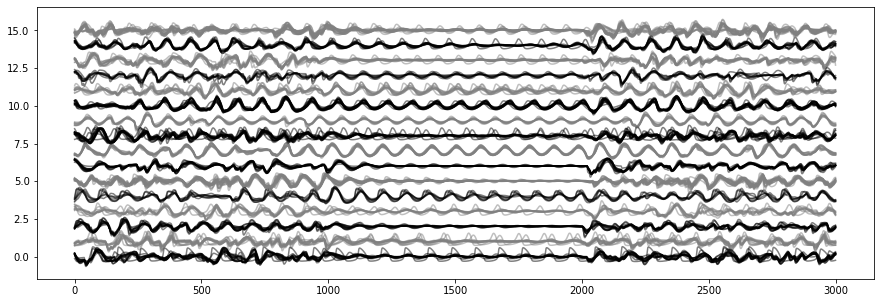

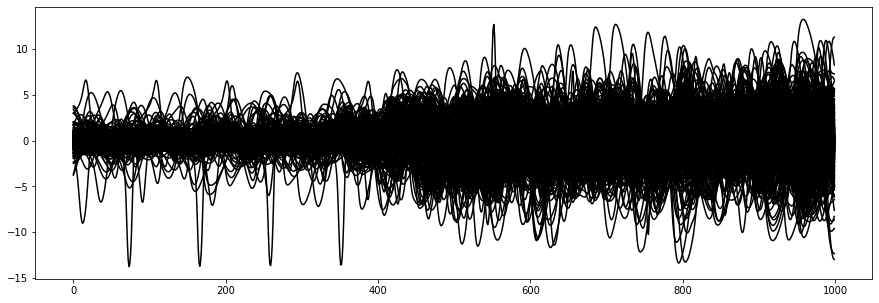

In [5]:
plt.figure(figsize=(15, 5))

def s(v):
    import scipy.optimize
    v = v - v.mean()
    def loss(a):
        a = int(a)
        L = abs(v[1500:2500] - v[1500+a:2500+a]).sum()
        return L
    a = min(range(100, 500), key=loss)
    return v[1500:2500] - v[1500+a:2500+a]

for n, vs in zip(recipe.neurons, vsall):
    v = vs[tstart:tfinal]
    v = (v - v.mean()) / v.ptp()
    if n.cluster > 15: continue
    plt.plot(v + n.cluster, color=['black', 'gray'][n.cluster%2], alpha=0.5)

plt.figure(figsize=(15, 5))
for n, vs in zip(recipe.neurons, vsall):
    v = vs[tstart:tfinal]
    v = (v - v.mean())
    if n.cluster > 100: continue
    v = s(v)
    plt.plot(v, color='black')#, alpha=n.cluster/15)
#plt.xlim([1500, 2400])
#plt.ylim([-3, 0])

In [6]:
## Option 1: Sample 2d grid in a plane of random neurons

if False:
    N_SAMPLES = 64 # along 1 dimension. values > 10 = slow
    a = random.choice(recipe.neurons)
    a = np.array([a.x, a.y, a.z])
    b = random.choice(recipe.neurons)
    b = np.array([b.x, b.y, b.z])
    c = random.choice(recipe.neurons)
    c = np.array([c.x, c.y, c.z])
    u = b - a
    v = c - a
    point = np.array([a, b, c]).mean(0)
    normal = np.cross(u, v)
    normal = normal / np.linalg.norm(normal)
    scale = np.array([np.linalg.norm(b - a), np.linalg.norm(c - a), np.linalg.norm(b - c)]).mean()
    e0 = b - a
    e1 = np.cross(e0, b)
    e0 = e0 / np.linalg.norm(e0)
    e1 = e1 / np.linalg.norm(e1)
    s = np.linspace(-scale*0.8, scale*0.8, N_SAMPLES)
    Xplane, Yplane = np.meshgrid(s, s)
    X, Y, Z = point[:, None] + Xplane.flatten()[None, :]*e0[:, None] + Yplane.flatten()[None, :]*e1[:, None]
    lsps = []
    Ms = []
    geometries = []
    for gid in range(recipe.num_cells()):
        segtree = recipe.cell_morphology(gid)
        p = arbor.place_pwlin(arbor.morphology(segtree))
        cell_geometry = ArborCellGeometry(p, I_meta[gid])
        lsp = ArborLineSourcePotential(cell=cell_geometry, x=X, y=Y, z=Z)
        M = lsp.get_transformation_matrix()
        geometries.append(cell_geometry)
        lsps.append(lsp)
        Ms.append(M)
        print(gid, end=' ')
    V_ext = 0
    for gid in range(recipe.num_cells()):
        V_ext = V_ext + np.nan_to_num(Ms[gid] @ I_m[gid])
    V_ext = V_ext.reshape((N_SAMPLES, N_SAMPLES, -1))

In [7]:
%%time

## Option 2: Sample along a z-slice of the full IO at high resolution

N_SAMPLES = 64 # along 1 dimension. values > 10 = slow
soma = np.array([(a.x, a.y, a.z) for a in recipe.neurons]).T

sx = np.linspace(soma[0].min(), soma[0].max(), N_SAMPLES)
sy = np.linspace(soma[1].min(), soma[1].max(), N_SAMPLES)
z0 = soma[2].mean()
e = np.eye(3)

Xplane, Yplane = np.meshgrid(sx, sy)
X, Y, Z = (e[0]*Xplane.reshape(-1, 1) + e[1]*Yplane.reshape(-1, 1) + e[2]*z0).T
lsps = []
Ms = []
geometries = []
for gid in range(recipe.num_cells()):
    segtree = recipe.cell_morphology(gid)
    p = arbor.place_pwlin(arbor.morphology(segtree))
    cell_geometry = ArborCellGeometry(p, I_meta[gid])
    lsp = ArborLineSourcePotential(cell=cell_geometry, x=X, y=Y, z=Z)
    M = lsp.get_transformation_matrix()
    geometries.append(cell_geometry)
    lsps.append(lsp)
    Ms.append(M)
    if gid % 5 == 0:
        print(gid, end=' ', flush=True)
        

0 5 10 15 20 25 30 35 40 45 50 55 60 65 70 75 80 85 90 95 100 105 110 115 120 125 130 135 140 145 150 155 160 165 170 175 180 185 190 195 200 205 210 215 220 225 230 235 240 245 250 255 260 265 270 275 280 285 290 295 300 305 310 315 320 325 330 335 340 345 350 355 360 365 370 375 380 385 390 395 400 405 410 415 420 425 430 435 440 445 450 455 460 465 470 475 480 485 490 495 500 505 510 515 520 525 530 535 540 545 550 555 560 565 570 575 580 585 590 595 600 605 610 615 620 625 630 635 640 645 650 655 660 665 670 675 680 685 690 695 700 705 710 715 720 725 730 735 740 745 750 755 760 765 770 775 780 785 790 795 800 805 810 815 820 825 830 835 840 845 850 855 860 865 870 875 880 885 890 895 900 905 910 915 920 925 930 935 940 945 950 955 960 965 970 975 CPU times: user 23min 27s, sys: 1h 26min 39s, total: 1h 50min 6s
Wall time: 2min 17s


In [8]:
%%time
V_ext = 0
for gid in range(recipe.num_cells()):
    V_ext = V_ext + np.nan_to_num(Ms[gid] @ I_m[gid])
V_ext = V_ext.reshape((N_SAMPLES, N_SAMPLES, -1))

CPU times: user 4min 35s, sys: 21min 47s, total: 26min 22s
Wall time: 25.7 s


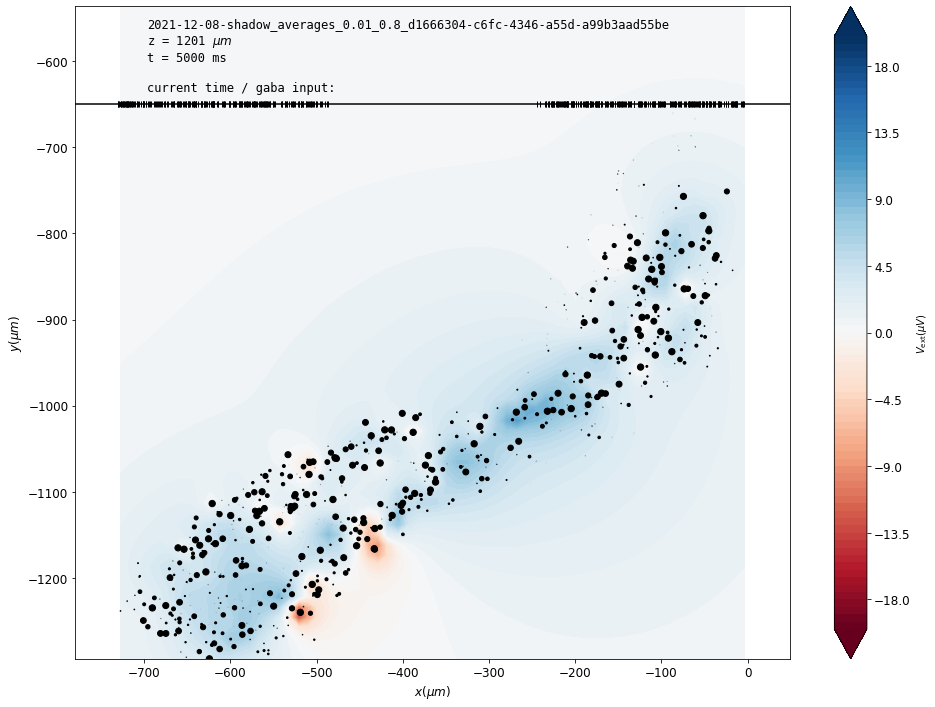

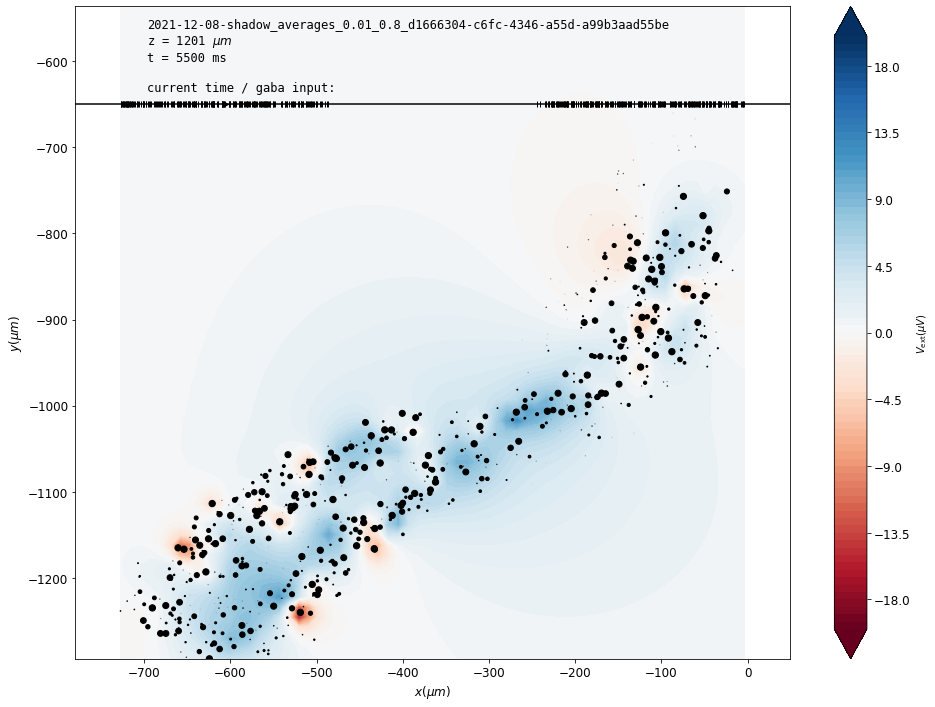

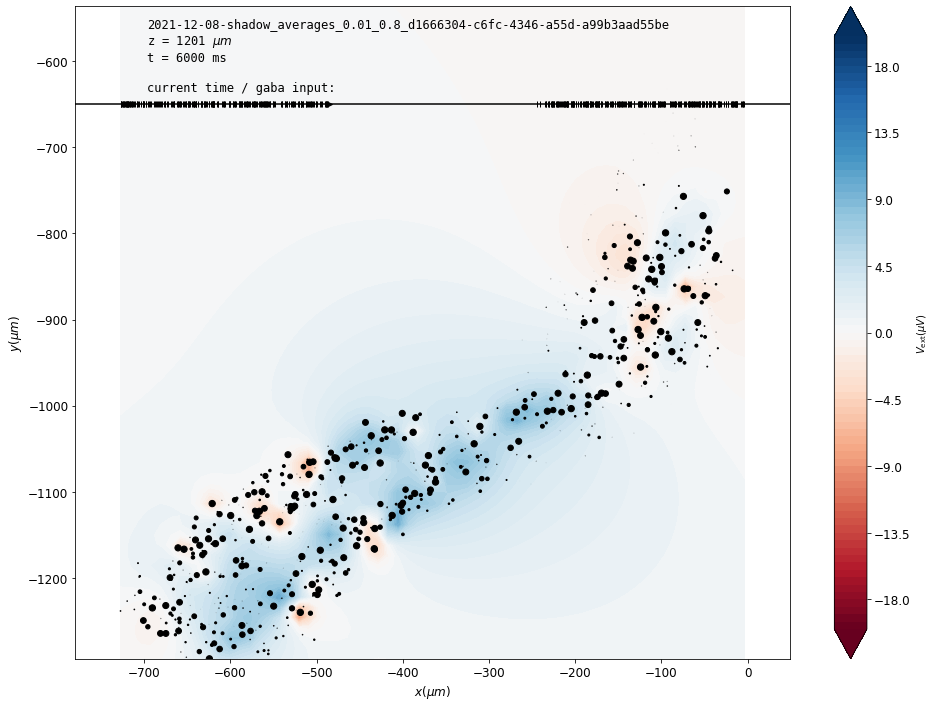

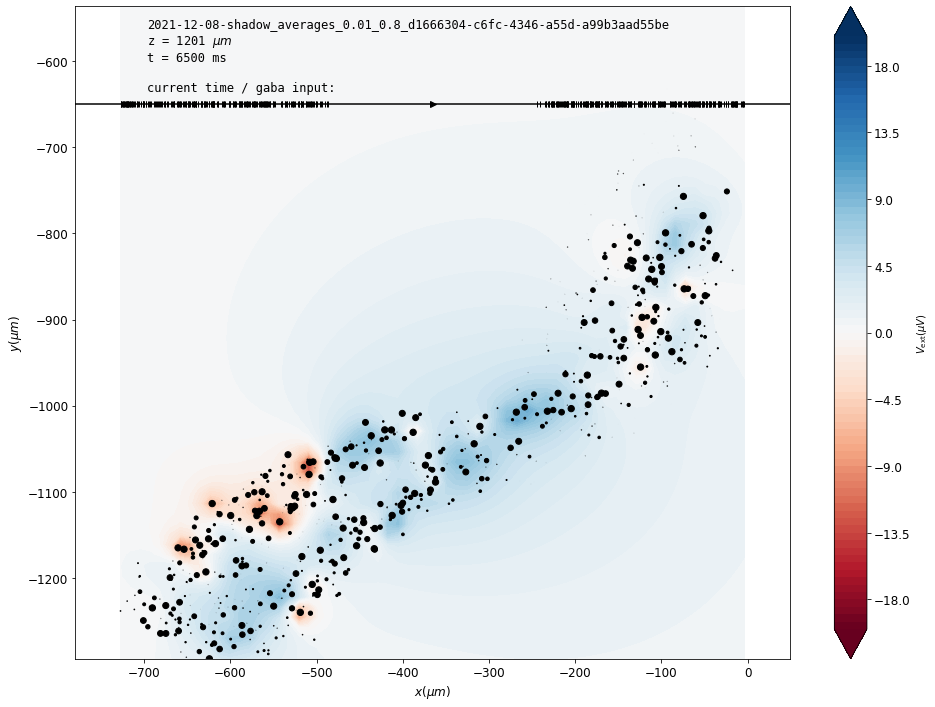

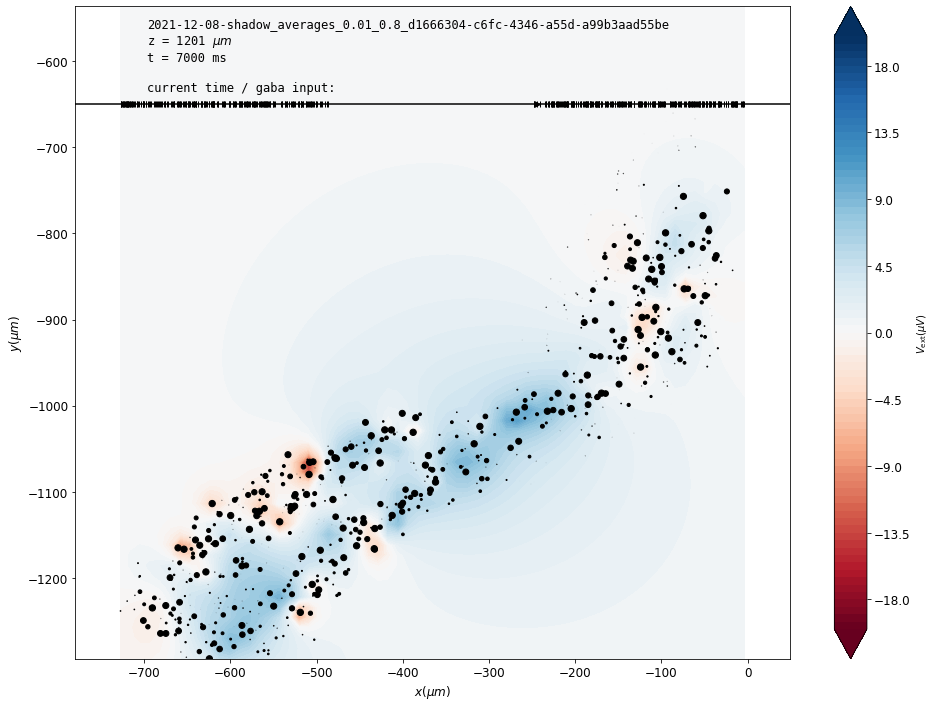

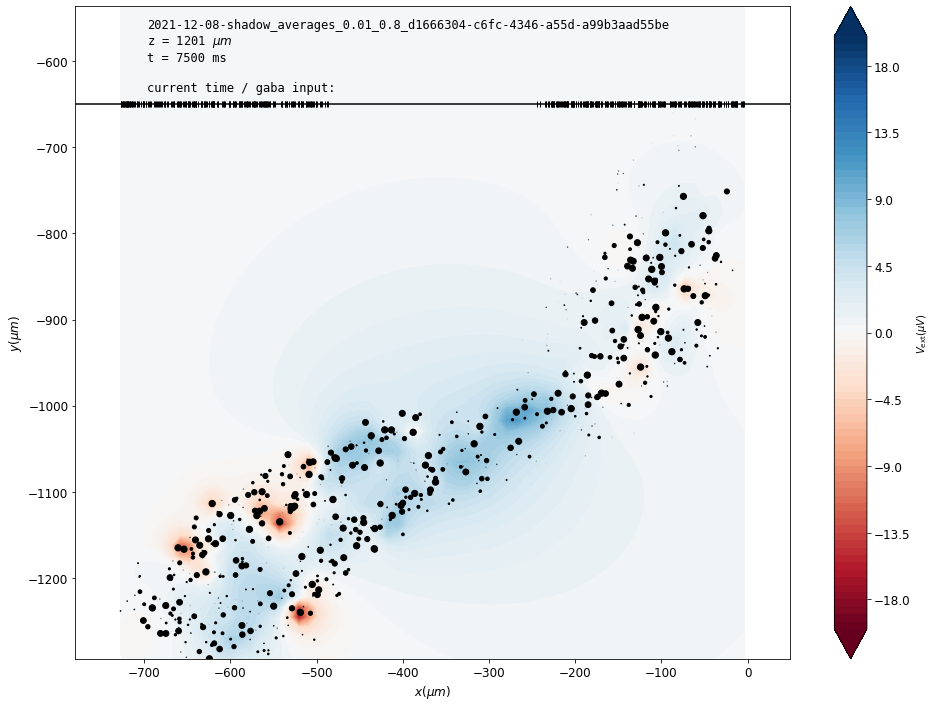

In [11]:
def plot_lfp(i, lim=None):
    if lim is None:
        lim = float(f'{abs(V_ext).max() / 3:.1e}')
    lim *= 1000
    levels = np.linspace(-lim, lim, 81)
    plt.contourf(Xplane, Yplane, V_ext[..., i]*1000, cmap='RdBu', levels=levels, extend='both')
    cbar = plt.colorbar(label=r'$V_{\mathrm{ext}} (\mu V)$')
    plt.axis('equal')
    plt.xlabel(r'$x (\mu m)$')
    plt.ylabel(r'$y (\mu m)$')
    dz = abs(soma[2] - z0)
    lim = 500
    xx, yy = soma[0:2, dz < lim]
    dz = dz[dz < lim]
    plt.scatter(xx, yy, s=40*np.exp(-dz**2/100**2), color='black')
    plt.text(0.1, 0.87, f'''{selected}
z = {z0:.0f} $\mu m$
t = {time[i]:.0f} ms

current time / gaba input:''', transform=plt.gca().transAxes, fontsize=12, fontfamily='monospace')
    [xmin, xmax] = plt.xlim()
    [ymin, ymax] = plt.ylim()
    y0 = ymax - (ymax-ymin)*0.15
    xr = xmax - xmin
    tmin, tmax = time.min(), time.max()
    ti = xmin + (time[i]-tmin)/(tmax - tmin)*xr
    plt.axhline(y0, color='black')
    plt.plot(ti, y0, '>', color='black')
    for at, s in recipe.spikes:
        if not (tmin <= at <= tmax): continue
        ti = xmin + (at-tmin)/(tmax - tmin)*xr
        spikez = s[2]
        spiker = s[3]
        r = abs(spikez-z0)/spiker
        if np.exp(-r**2) > 0.10:
            plt.plot(ti, y0, '|', color='black')
    ax = plt.gca()
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                 ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(12)
    cbar.ax.tick_params(labelsize=12)
for i in range(0, time.shape[0], 100):
    fig = plt.figure(figsize=(16, 12))
    fig.patch.set_facecolor('white')
    plot_lfp(i, lim=0.02)

Text(0.5, 1.0, 'Average Vsoma + Std.')

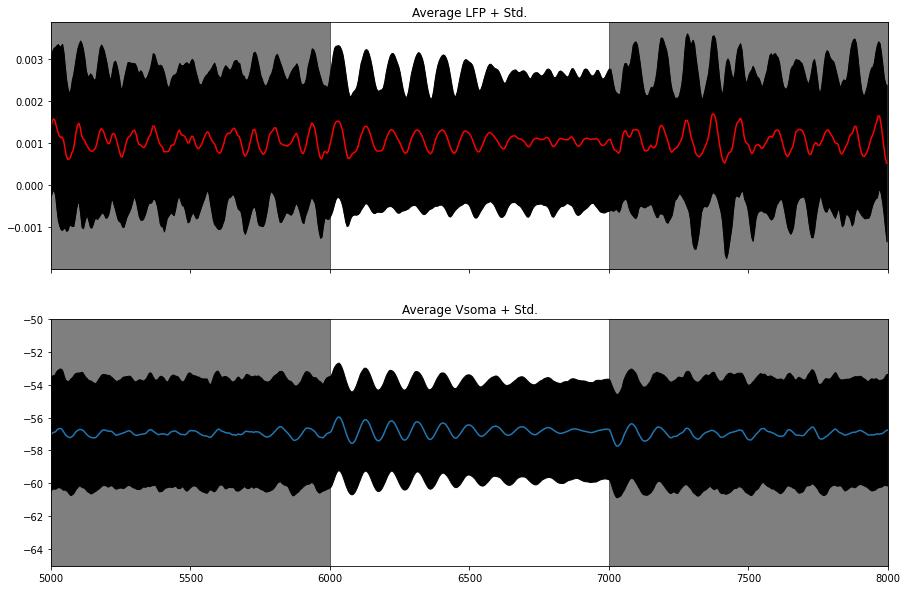

In [12]:
fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(15, 10))
flat = V_ext.reshape(-1, V_ext.shape[2])
ax[0].fill_between(time, flat.mean(0)-flat.std(0),  flat.mean(0)+flat.std(0), color='gray')
#plt.plot([at for at in spikes], [0.002 for at in spikes], 'x')
#ax[0].set_xlim([tstart, tfinal])
a, b = ax[0].get_ylim()
ax[0].fill_between([tstart, tstart+d], a, b, color='black',alpha=0.5)
ax[0].fill_between([tstart+2*d, tfinal], a, b, color='black', alpha=0.5)
ax[0].fill_between(time, flat.mean(0)-flat.std(0),  flat.mean(0)+flat.std(0), color='black')
ax[0].plot(time, flat.mean(0), color='red')
ax[0].set_ylim([a, b])
v = np.nan_to_num(vsall)
ax[1].fill_between(np.arange(v.shape[1]), v.mean(0)-v.std(0), v.mean(0)+v.std(0), color='black')
a, b = ax[1].get_ylim()
ax[1].fill_between([tstart, tstart+d], a, b, color='black',alpha=0.5)
ax[1].fill_between([tstart+2*d, tfinal], a, b, color='black', alpha=0.5)
ax[1].set_ylim([a, b])
ax[1].plot(v.mean(0))
ax[1].set_xlim([tstart, tfinal])
ax[1].set_ylim([-65, -50])
ax[0].set_title('Average LFP + Std.')
ax[1].set_title('Average Vsoma + Std.')

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 27

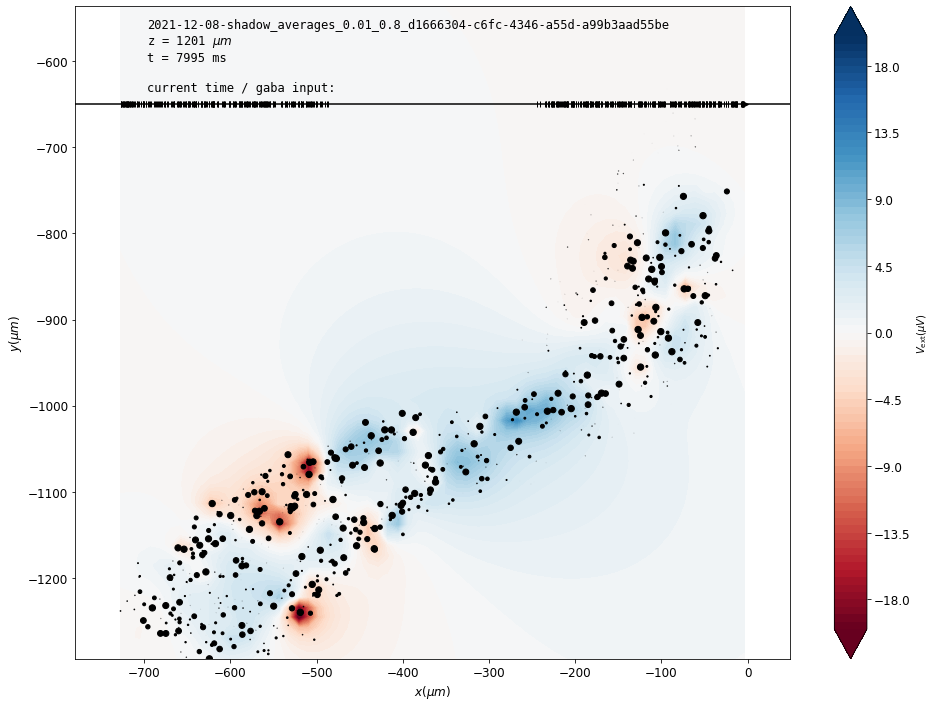

In [13]:
%%time
fig = plt.figure(figsize=(16, 12))

!rm -fr img/highc_100khz_v2
!mkdir img/highc_100khz_v2

frames = []
for i in range(0, V_ext.shape[2], 1):
    fig.clf()
    fig.patch.set_facecolor('white')
    plot_lfp(i, lim=0.02)
    plt.savefig("img/highc_100khz_v2/%05d.png" % i)
    print(i, end=' ', flush=True)
    
# ffmpeg -framerate 20 -i img/highc_100khz/%05d.png -r 30 -pix_fmt yuv420p highc_100khz.mp4

(-1000.0, -1300.0)

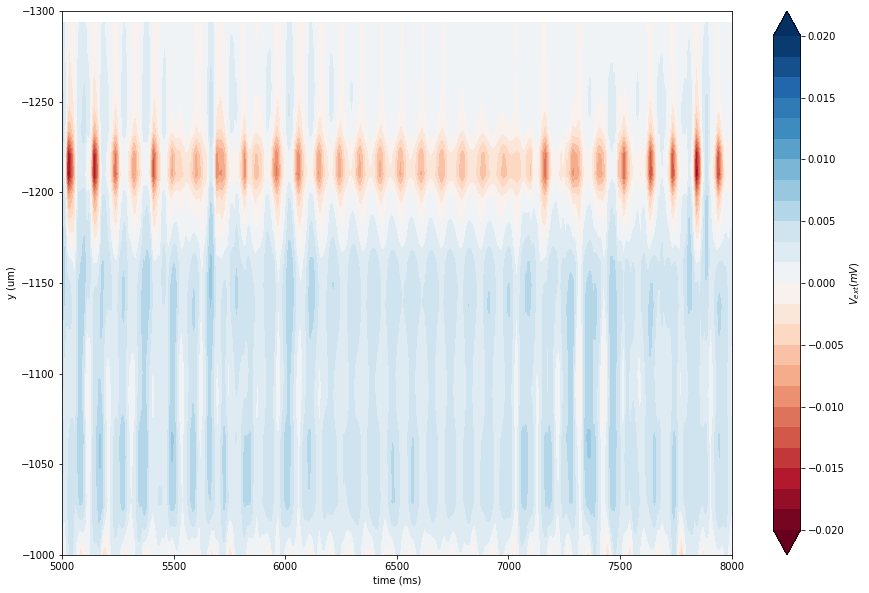

In [14]:
fig = plt.figure(figsize=(15, 10))
fig.patch.set_facecolor('white')
lim = float(f'{abs(V_ext).max() / 3:.1e}')
lim = 0.02
levels = np.linspace(-lim, lim, 25)
plt.contourf(V_ext[10, :, :], cmap='RdBu', levels=levels, extend='both',
             extent=(tstart, tfinal, Yplane.min(), Yplane.max()))
plt.colorbar(label='$V_{ext} (mV)$')
plt.xlabel('time (ms)')
plt.ylabel('y (um)')
plt.ylim([-1000, -1300])
#plt.savefig('img/lfp_space_time_line.pdf')
#plt.savefig('img/lfp_space_time_line.png')

In [15]:
s = []
for at, q in recipe.spikes.items():
    s.append([at, *q])
s = np.array(s)
np.savez_compressed(
    'lfp_highc_100khz',
    V_ext=V_ext,
    z0=z0,
    Xplane=Xplane,
    Yplane=Yplane,
    selected=selected,
    spikes=s,
    time=time,
    vsoma=vsall
)

AttributeError: 'list' object has no attribute 'items'

In [16]:
%%time
I_q  = [0*tmem[0][:,1:].T + stim[0][:,1:].T for tmem, stim in zip(tmem_current_traces, stim_current_traces)]
Vq = 0
for gid in range(recipe.num_cells()):
    Vq = Vq + np.nan_to_num(Ms[gid] @ I_q[gid])
Vq = Vq.reshape((N_SAMPLES, N_SAMPLES, -1))

CPU times: user 4min 41s, sys: 21min 9s, total: 25min 51s
Wall time: 25.6 s


(-1000.0, -1300.0)

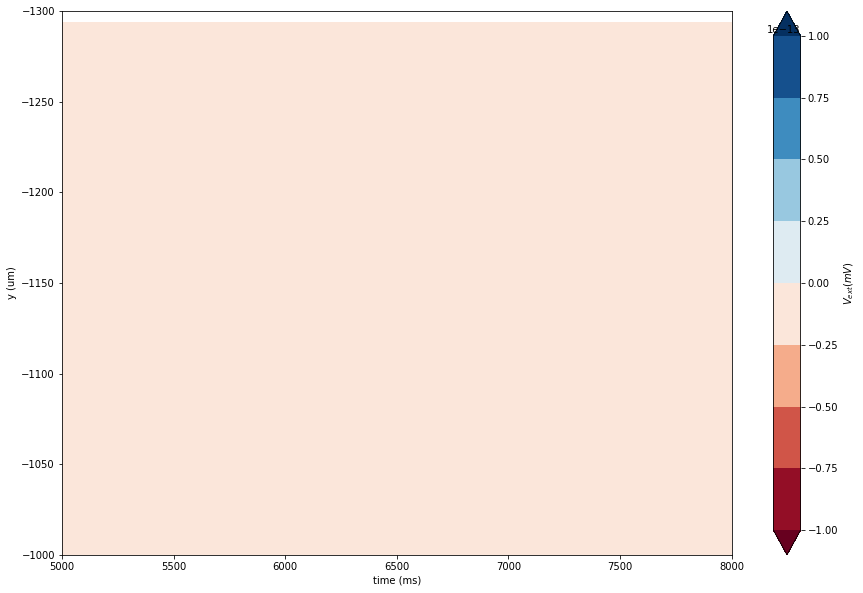

In [20]:
fig = plt.figure(figsize=(15, 10))
fig.patch.set_facecolor('white')
lim = float(f'{abs(Vq).max() / 3:.1e}')
#lim = 0.02
levels = np.linspace(-lim, lim, 25)
plt.contourf(Vq[10, :, :], cmap='RdBu', levels=levels, extend='both',
             extent=(tstart, tfinal, Yplane.min(), Yplane.max()))
plt.colorbar(label='$V_{ext} (mV)$')
plt.xlabel('time (ms)')
plt.ylabel('y (um)')
plt.ylim([-1000, -1300])

# Analyze LFP's

In [21]:
from sklearn.decomposition import PCA

In [22]:
pca = PCA(whiten=True)
v = np.nan_to_num(vsall[:,tstart:tfinal:5])
y = pca.fit_transform(flat.T)
flat.shape, y.shape, v.shape

((4096, 600), (600, 600), (979, 600))

(0.0, 20.0)

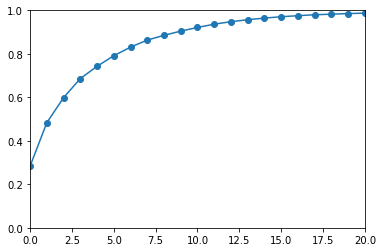

In [23]:
plt.plot(np.cumsum(pca.explained_variance_ratio_), 'o-')
plt.ylim([0, 1])
plt.xlim([0, 20])

In [24]:
y[:,:10].shape

(600, 10)

/tmp/ipykernel_7902/3196890309.py:12: RuntimeWarning: invalid value encountered in true_divide
  q = q / q.std()


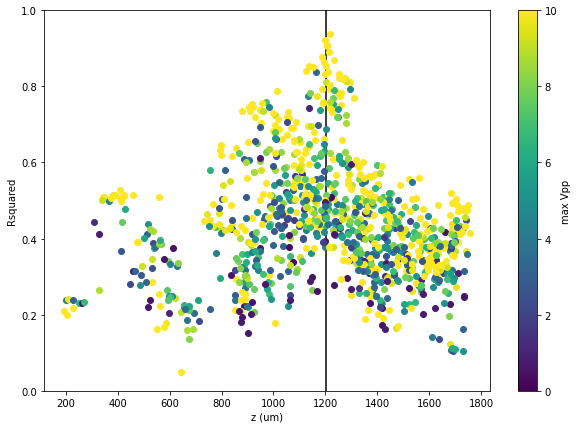

In [25]:
import matplotlib as mpl
ncomp = 5
cmap = plt.get_cmap('viridis')
plt.figure(figsize=(10, 7))
plt.axvline(z0, color='black')
norm = mpl.colors.Normalize(vmin=0, vmax=10)
sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)

for i in  range(len(v)):
    q = v[i]
    q = q - q.mean()
    q = q / q.std()
    c = (q @ y[:, :ncomp])
    v0 = (c * y[:, :ncomp]).sum(1)
    v0 = v0 / v0.std()
    R2 = 1 - ((q - v0)**2).sum() / (
        np.sum(v0**2) + np.sum(q**2))
    z = recipe.neurons[i].z
    plt.plot(z, R2, 'o', color=cmap(norm(v[i].ptp())))
plt.ylim([0, 1])
plt.ylabel('Rsquared')
plt.xlabel('z (um)')
plt.colorbar(sm, label='max Vpp')

Text(0, 0.5, 'PCA no.')

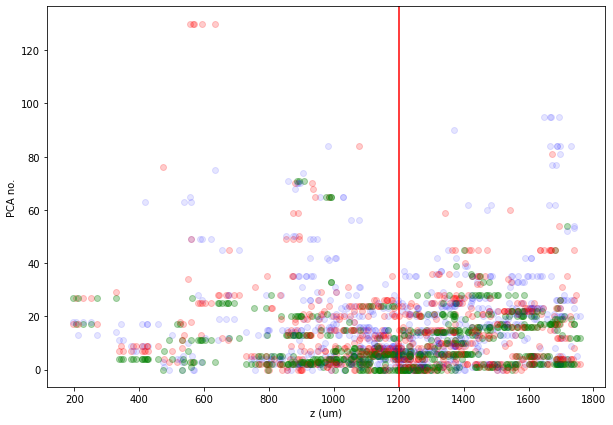

In [26]:
plt.figure(figsize=(10, 7))
for i in range(len(v)):
    q = v[i]
    if q.ptp() < 5:
        continue
    q = q - q.mean()
    q = q / q.std()
    j = (q @ y).argsort()
    plt.plot(neurons[i].z, j[-1], 'o', alpha=0.3, color='green')
    plt.plot(neurons[i].z, j[-2], 'o', alpha=0.2, color='red')
    plt.plot(neurons[i].z, j[-3], 'o', alpha=0.1, color='blue')
plt.axvline(z0, color='red')
plt.xlabel('z (um)')
plt.ylabel('PCA no.')

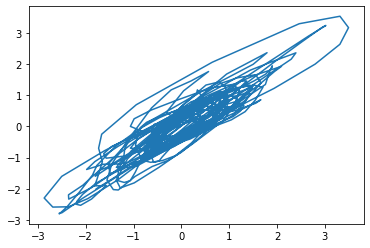

In [27]:
plt.plot(q, v0)

In [29]:
target = np.array([
    [at, x, y, z] for at, (x, y, z, r, w, typ) in spikes.items() if abs(z - z0) < 10
])
Tone = time[:200]
Ttwo = time[400:]
Xone = y[:200]
Xtwo = y[400:]
Yone = target[(target.T[0] > 5000) & (target.T[0] < 6000)]
Ytwo = target[(target.T[0] > 7000) & (target.T[0] < 8000)]


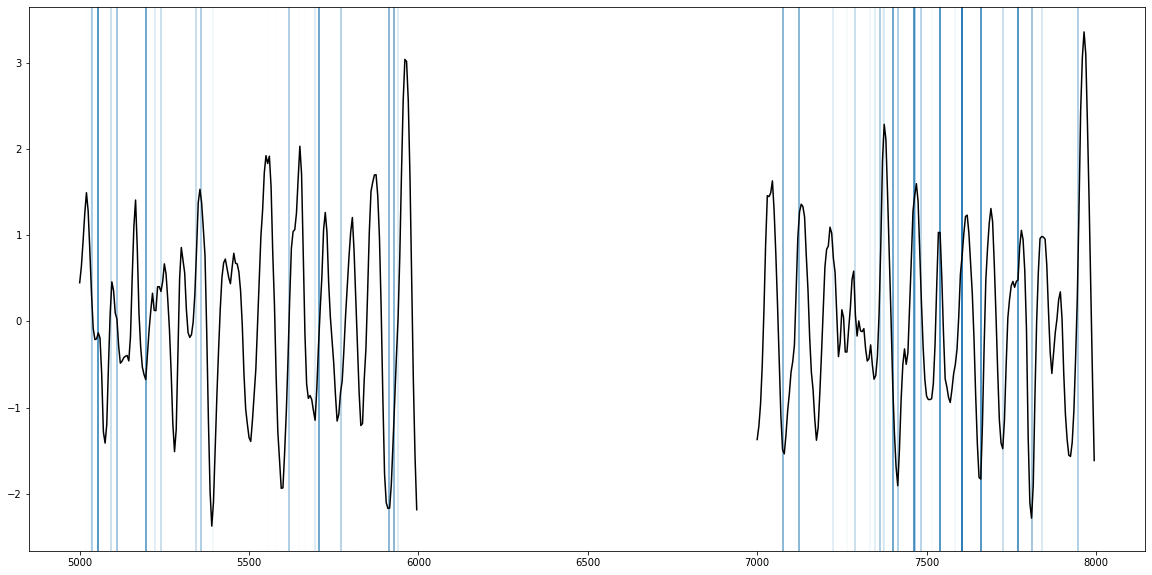

In [30]:
plt.figure(figsize=(20, 10))
[plt.axvline(at, alpha=np.exp(-(z-z0)**2/10)) for at, x, y, z in Yone];
[plt.axvline(at, alpha=np.exp(-(z-z0)**2/10)) for at, x, y, z in Ytwo];
plt.plot(Tone, Xone[:,3], color='black')
plt.plot(Ttwo, Xtwo[:,3], color='black')

(4850.25, 8144.75, -8.948565279722196, 125.80108158118418)

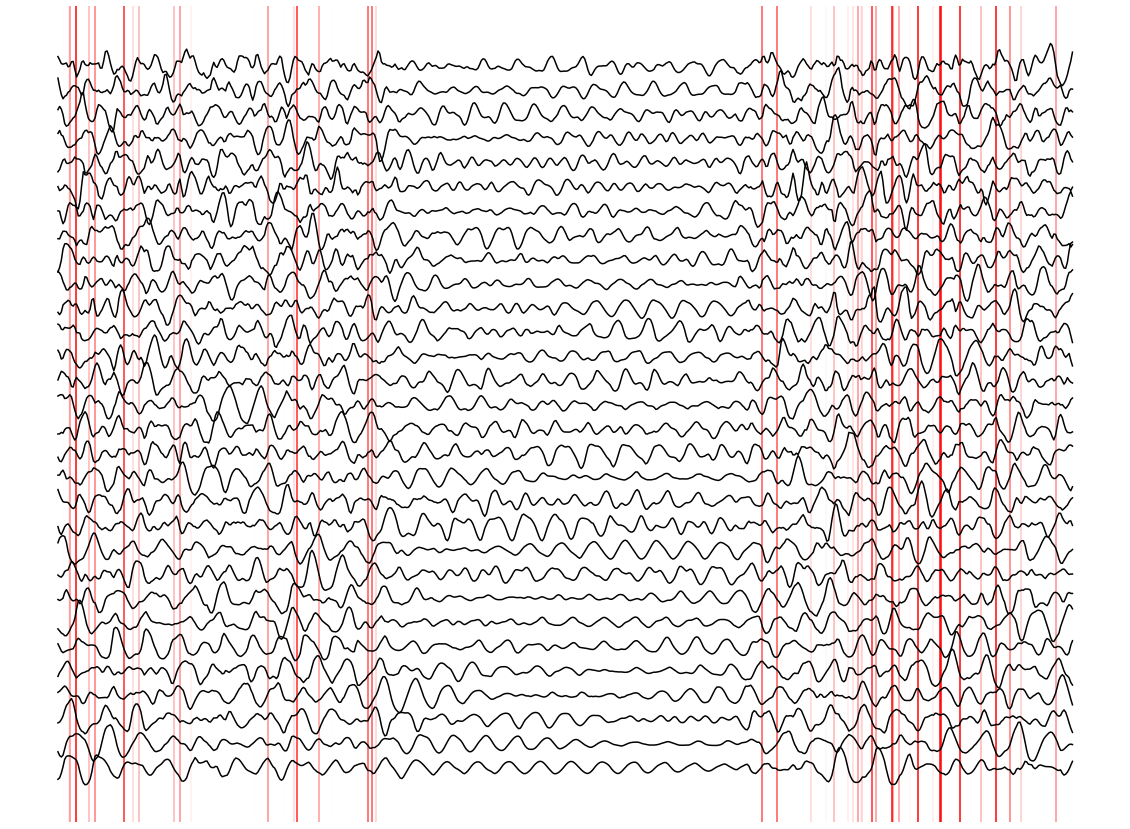

In [31]:
plt.figure(figsize=(20, 15))
[plt.axvline(at, alpha=np.exp(-(z-z0)**2/10), color='red') for at, x, y, z in target if at > 5000];
for i in range(30):
    plt.plot(time, y.T[i] + 4*i, color='black');
plt.axis('off')

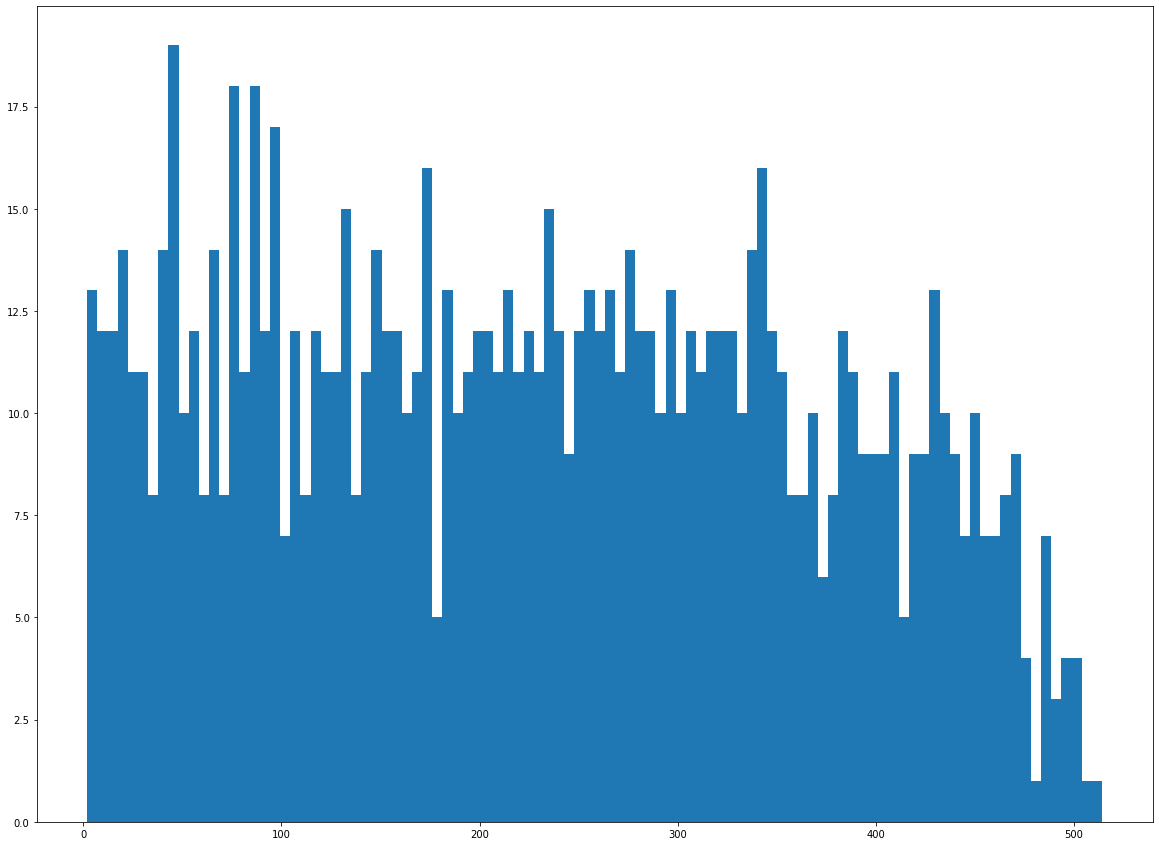

In [32]:
plt.figure(figsize=(20, 15))
import scipy.signal
peaks = []
for i in range(10):
    p = scipy.signal.find_peaks(y[i], prominence=1)[0]
    peaks.extend(p)
plt.hist(peaks, bins=100);

Text(0.5, 0, 'Time after spike (ms)')

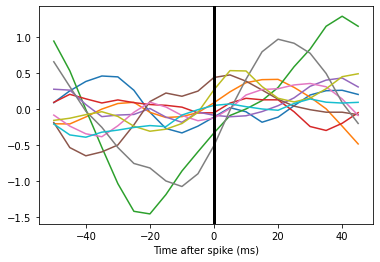

In [33]:
size = 10
for pca_idx in range(10):
    T = np.arange(-size, size)*5
    l = 0
    n = 0
    for at, sx, sy, sz in target:
        if abs(sz - z0) > 1:
            continue
        at = np.random.randint(5000, 6000)
        if at < 5000:
            continue
        idx = (at - 5000) / 5
        idx = int(round(idx))
        if idx <= size:
            continue
        w = np.exp(-(sz-z0)**2/10)
        q = y[idx-size:idx+size, pca_idx]
        if len(q) != size*2:
            continue
        #plt.plot(T, q, color='black', alpha=0.1)
        l = l + q
        n += 1
    plt.plot(T, l / n)
plt.axvline(0, color='black', lw=3)
plt.xlabel('Time after spike (ms)')

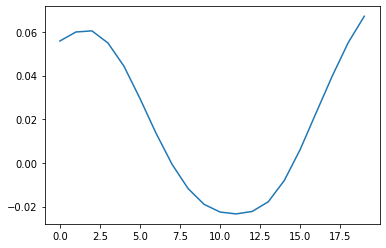

In [34]:
l = 0
for i in range(100000):
    at = np.random.randint(0, 200)
    l = l + y[at:at+20,0]
plt.plot(l/i)

In [10]:
l

NameError: name 'l' is not defined